# Phase 3 Data Science Training Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray 
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime

## Exploratory Data Analysis

### Fetch data

In [2]:
# Get batch data
def getData(batch_name):
    # file path, might need to update depending on user folder structure
    path = "X:\\MSA_Phase_3_Submission\\data_science_submission_phase3\\data\\cifar-10-python\\cifar-10-batches-py\\"
    return unpickle(path+batch_name)

# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Get data
data_batch_1 = getData('data_batch_1')
data_batch_2 = getData('data_batch_2')
data_batch_3 = getData('data_batch_3')
data_batch_4 = getData('data_batch_4')
data_batch_5 = getData('data_batch_5')
test_batch = getData('test_batch')

### Understand data

In [3]:
# Tells us data is a dictionary
#print(type(batch1_data)) 

# Get keys
print(data_batch_1.keys())

# Get data shape
print ('Current batch label 👇')
print(data_batch_1[b'batch_label'])

print ('Length of labels list👇')
print(len(data_batch_1[b'labels']))

print ('data shape 👇')
print(data_batch_1[b'data'].shape)

print ('Length of filenames list 👇')
print(len(data_batch_1[b'filenames']))

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Current batch label 👇
b'training batch 1 of 5'
Length of labels list👇
10000
data shape 👇
(10000, 3072)
Length of filenames list 👇
10000


### Accumulate Data

In [4]:
# Accumulate image data
accumulated_image_data = np.append(data_batch_1[b'data'], data_batch_2[b'data'], axis=0)
accumulated_image_data = np.append(accumulated_image_data, data_batch_3[b'data'], axis=0)
accumulated_image_data = np.append(accumulated_image_data, data_batch_4[b'data'], axis=0)
accumulated_image_data = np.append(accumulated_image_data, data_batch_5[b'data'], axis=0)

# Accumulate label data
accumulated_label_data = np.append(data_batch_1[b'labels'], data_batch_2[b'labels'], axis=0)
accumulated_label_data = np.append(accumulated_label_data, data_batch_3[b'labels'], axis=0)
accumulated_label_data = np.append(accumulated_label_data, data_batch_4[b'labels'], axis=0)
accumulated_label_data = np.append(accumulated_label_data, data_batch_5[b'labels'], axis=0)

# print data shapes
print(accumulated_image_data.shape)
print(accumulated_label_data.shape)

# print test data shapes
print(test_batch[b'data'].shape)
print(len(test_batch[b'labels']))

(50000, 3072)
(50000,)
(10000, 3072)
10000


## Data processing

### Reshape data

In [5]:
# Reshape training image data together
reshape_train_x = accumulated_image_data
reshape_train_x = reshape_train_x.reshape(len(reshape_train_x), 3, 32, 32).transpose(0, 2, 3, 1)

# Reshape testing image data

reshape_test_x = np.array(test_batch[b'data'])
reshape_test_x = reshape_test_x.reshape(len(reshape_test_x), 3, 32, 32).transpose(0, 2, 3, 1)

# Reshape test y
reshape_test_y = np.array(test_batch[b'labels'])

# Verify shapes
print(reshape_train_x.shape)
print(reshape_test_x.shape)
print(reshape_test_y.shape)


(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10000,)


### Render Sample Image data

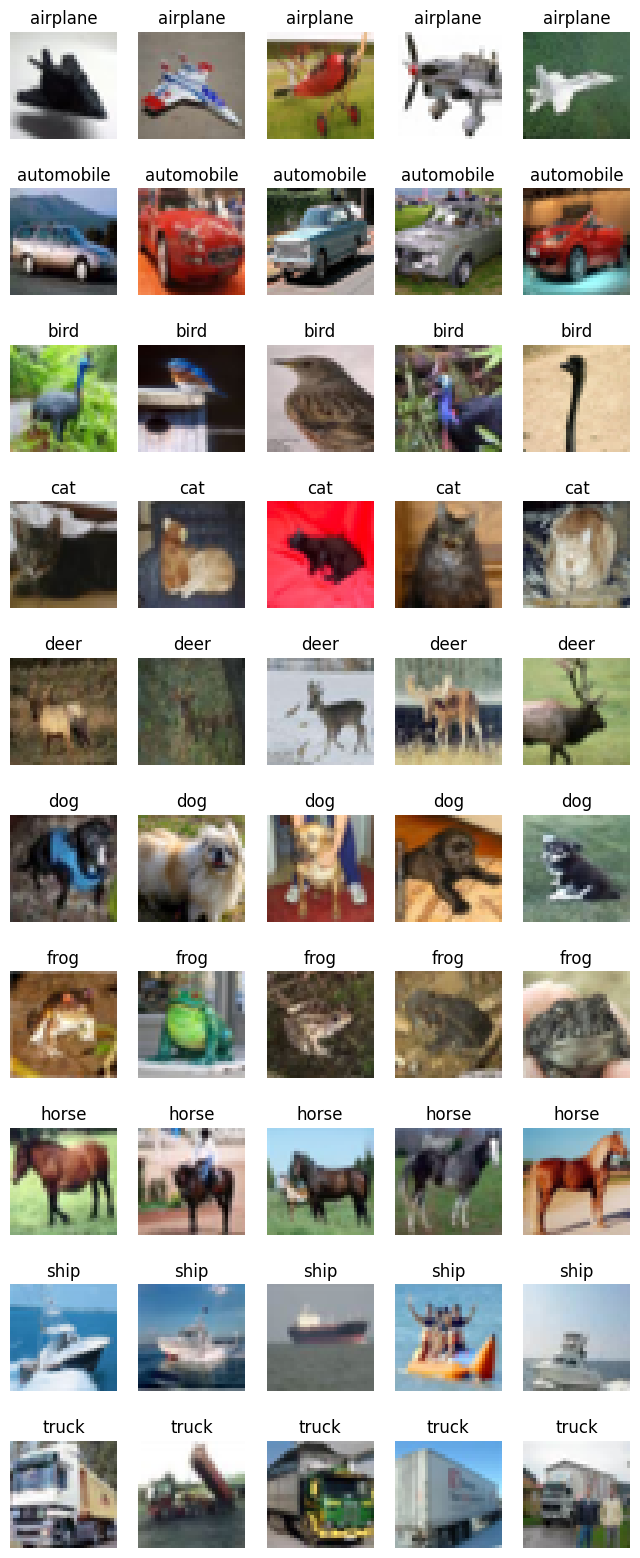

In [6]:
label_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure(figsize=(8, 20))

for label in range(10): # Does not include 10.
    search_results = np.where(accumulated_label_data == label)[0][:5]

    for index, img_index in enumerate(search_results):
        current_index = label * 5 + index + 1
        ax = plt.subplot(10,5, current_index)
        plt.imshow(reshape_train_x[img_index], cmap="gray")
        plt.title(label_names[label])
        plt.axis("off")

### Turn RGB Data to Grayscale

In [7]:
# training x to grayscale
grayscale_train_x = [rgb2gray(img) for img in reshape_train_x]

# testing y to grayscale
grayscale_test_x = [rgb2gray(img) for img in reshape_test_x]
    
# turn back to numpy array
grayscale_train_x = np.array(grayscale_train_x)
grayscale_test_x = np.array(grayscale_test_x)

### Modify labels to suit detection for selected label - 3 (Cat)

In [8]:
train_y = []
test_y = []

# Filter training data
for x in accumulated_label_data:
    if x == 3:
        train_y.append(1)
    else:
        train_y.append(0)
        
# Filter test data
for x in reshape_test_y:
    if x == 3:
        test_y.append(1)
    else:
        test_y.append(0)

# Convert back to numpy arrays
train_y = np.array(train_y)
test_y = np.array(test_y)

### Final setup for Data

In [9]:
sliced_train_x = grayscale_train_x[0:10000]
sliced_train_y = train_y[0:10000]

sliced_test_x = grayscale_test_x[0: 2000]
sliced_test_y = test_y[0:2000]

## Data modelling

### Model

In [10]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(layers.Flatten(input_shape=(32,32))) # input layer modified to accept data shape of (32, 32, 3)
    model.add(layers.Dense(50, activation='relu')) # hidden layer 1
    model.add(layers.Dense(50, activation='relu')) # hidden layer 2
    model.add(layers.Dense(25, activation='relu')) # hidden layer 3
    model.add(layers.Dense(1, activation='sigmoid', name="Output_Probability")) # output layer
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.000005), # reduced from 0.01 also change to Adam from SGD
        loss=losses.BinaryCrossentropy(), # Loss metric. changed to binary from sparse
        metrics=['accuracy'] # changed from accuracy
    )

    return model

### Fit model

In [11]:
# Check whether GPU is recognised
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
model = generateModel()

log_dir = 'output/logs/%s' % datetime.now().strftime("%Y-%m-%d-%H_%M_%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit(sliced_train_x, sliced_train_y,
    validation_data=(sliced_test_x, sliced_test_y),
    epochs= 10,
    batch_size=750, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    #verbose=0 # Uncomment this line to reduce the printing on console.
)

Epoch 1/10
14/14 [==============================] - 2s 52ms/step - loss: 0.6183 - accuracy: 0.8576 - val_loss: 0.6046 - val_accuracy: 0.8865
Epoch 2/10
14/14 [==============================] - 0s 26ms/step - loss: 0.5929 - accuracy: 0.8860 - val_loss: 0.5784 - val_accuracy: 0.8965
Epoch 3/10
14/14 [==============================] - 0s 26ms/step - loss: 0.5669 - accuracy: 0.8943 - val_loss: 0.5514 - val_accuracy: 0.9000
Epoch 4/10
14/14 [==============================] - 0s 24ms/step - loss: 0.5407 - accuracy: 0.8977 - val_loss: 0.5243 - val_accuracy: 0.9005
Epoch 5/10
14/14 [==============================] - 0s 27ms/step - loss: 0.5145 - accuracy: 0.8983 - val_loss: 0.4979 - val_accuracy: 0.9005
Epoch 6/10
14/14 [==============================] - 0s 21ms/step - loss: 0.4895 - accuracy: 0.8984 - val_loss: 0.4732 - val_accuracy: 0.9005
Epoch 7/10
14/14 [==============================] - 0s 28ms/step - loss: 0.4666 - accuracy: 0.8984 - val_loss: 0.4508 - val_accuracy: 0.9005
Epoch 8/10
14

In [13]:
model.save('output/my_model')

INFO:tensorflow:Assets written to: output/my_model\assets


In [14]:
model.summary()

Model: "Image_Recognition_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 50)                51250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 Output_Probability (Dense)  (None, 1)                 26        
                                                                 
Total params: 55,101
Trainable params: 55,101
Non-trainable params: 0
_________________________________________________________________


## Hyper parameter tuning

For hyper parameter tuning I was chosen to keep changing the no. of neurons in my 2nd, 3rd and 4th layers and evaluate the results.

In [19]:
# List hyperparameters
layer2 = [50, 100, 150]
layer3 = [60, 110, 160]
layer4 = [20 , 30, 40]

# Modified generate model function.
def generateModel(layer2n, layer3n, layer4n):
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(layers.Flatten(input_shape=(32,32))) # input layer modified to accept data shape of (32, 32, 3)
    model.add(layers.Dense(layer2n, activation='relu')) # hidden layer 1
    model.add(layers.Dense(layer3n, activation='relu')) # hidden layer 2
    model.add(layers.Dense(layer4n, activation='relu')) # hidden layer 3
    model.add(layers.Dense(1, activation='sigmoid', name="Output_Probability")) # output layer
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.000005), # reduced from 0.01 also change to Adam from SGD
        loss=losses.BinaryCrossentropy(), # Loss metric. changed to binary from sparse
        metrics=['accuracy'] # changed from accuracy
    )

    return model   

In [21]:
# Generate models
for x in range(3):
    print ('Using Hyperparameter %d settings' % x)
    model = generateModel(layer2[x], layer3[x], layer4[x])

    log_dir = 'output/logs/hyp%d%s' % (x, datetime.now().strftime("%Y-%m-%d-%H_%M_%S"))

    # Callbacks for QoL.
    tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

    model.fit(sliced_train_x, sliced_train_y,
        validation_data=(sliced_test_x, sliced_test_y),
        epochs= 2,
        batch_size=750, # Set this to a lower number if your computer spec is bad.
        callbacks=[tensorboard_callback, earlystop_callback],
        #verbose=0 # Uncomment this line to reduce the printing on console.
    )
    print ('-------------------------------------------------------------------------------------------------------------')

Using Hyperparameter 0 settings
Epoch 1/2
14/14 [==============================] - 1s 59ms/step - loss: 0.9024 - accuracy: 0.1050 - val_loss: 0.8800 - val_accuracy: 0.1000
Epoch 2/2
14/14 [==============================] - 1s 38ms/step - loss: 0.8571 - accuracy: 0.1084 - val_loss: 0.8363 - val_accuracy: 0.1075
-------------------------------------------------------------------------------------------------------------
Using Hyperparameter 1 settings
Epoch 1/2
14/14 [==============================] - 1s 59ms/step - loss: 0.6098 - accuracy: 0.8519 - val_loss: 0.5805 - val_accuracy: 0.8860
Epoch 2/2
14/14 [==============================] - 1s 41ms/step - loss: 0.5636 - accuracy: 0.8907 - val_loss: 0.5372 - val_accuracy: 0.8965
-------------------------------------------------------------------------------------------------------------
Using Hyperparameter 2 settings
Epoch 1/2
14/14 [==============================] - 1s 61ms/step - loss: 0.7414 - accuracy: 0.2623 - val_loss: 0.7085 - val_a